# Learn To Synchronize Videos

## Model declaration

In [1]:
from importlib import reload
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import sync_net
import trainer
import metrics
import data_loader
reload(sync_net)
reload(trainer)
reload(metrics)
reload(data_loader)
from sync_net import reset_first_layer, replace_last_layer, add_sigmoid_activation, TripletNet, MultiSiameseNet, TripletLoss, CosineSimilarityTripletLoss, LosslessTripletLoss, MultiSiameseCosineSimilarityLoss, SoftMultiSiameseCosineSimilarityLoss
from trainer import fit
from metrics import EmbeddingL2DistanceMetric, EmbeddingCosineSimilarityMetric, EmbeddingCosineSimilarityAndDistanceLossMetric
from data_loader import get_datasets, get_test_set, get_multisiamese_datasets, get_soft_multisiamese_datasets
# import wandb
# wandb.init(project="learn-to-synchronize-videos")
cuda = torch.cuda.is_available()

torch.cuda.set_device(0)
embedding_net = models.resnet50(pretrained=True)
# reset_first_layer(embedding_net)
replace_last_layer(embedding_net, 16)
# embedding_net = add_sigmoid_activation(embedding_net)  # Use only with LosslessTripletLoss
# model = TripletNet(embedding_net)
model = MultiSiameseNet(embedding_net)
model.cuda(0)
model = nn.DataParallel(model).cuda()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# loss_fn = TripletLoss(margin=0.5)
# loss_fn = CosineSimilarityTripletLoss(margin=0.5)
# loss_fn = LosslessTripletLoss()
# loss_fn = MultiSiameseCosineSimilarityLoss()
loss_fn = SoftMultiSiameseCosineSimilarityLoss()
scheduler = lr_scheduler.StepLR(optimizer, 5, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100
start_epoch = 0
save_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\soft_multisiamese_original_conv_diff_val"
if not os.path.isdir(save_path):
    os.makedirs(save_path)
# wandb.config.lr = lr
# wandb.config.optimizer = type(optimizer)
# wandb.config.loss_fn = type(loss_fn)
print("loaded")

loaded


## Load dataset

### Angio sequence triplets

In [ ]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_datasets(training_path, validation_path)

### Angio sequence multi siamese

In [2]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_multisiamese_datasets(training_path, validation_path, 1000, 64)

105 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
104 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
78 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
75 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30LAO25CRA
78 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30RAO
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_AP
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_LAT
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_AP
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_LAT
48 valid frames in C:\Users\root\Data\Angiogr

KeyboardInterrupt: 

### Angio sequence soft multi siamese

In [2]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\ABL-5'
max_cycles_for_pairs = 0
sequence = 3
training_set, validation_set = get_soft_multisiamese_datasets(training_path, validation_path, max_cycles_for_pairs, sequence, 1000, 64)

105 valid frames [32, 136] @21 in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames [50, 159] @22 in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
109 valid frames [44, 152] @22 in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
76 valid frames [56, 131] @20 in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames [53, 131] @21 in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames [35, 155] @21 in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames [35, 147] @20 in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
46 valid frames [23, 68] @12 in C:\Users\root\Data\Angiographie\AC-1\export\LCA_40RA015CAU
49 valid frames [26, 74] @11 in C:\Users\root\Data\Angiographie\AC-1\export\LCA_45LAO
53 valid frames [31, 83] @11 in C:\Users\root\Data\Angiographie\AC-1\export\LCA_AP
51 valid frames [33, 83] @11 in C:\Users\root\Data\Angiographie\AC-1\export\LCA_LAT
69 valid frames [32, 100] @12 in C:\Users\

### Load MNIST dataset instead

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transformations = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
mnist_trainset = datasets.MNIST(r"C:\Users\root\Data\MNIST", train=True, download=True, transform=transformations)

In [ ]:
from PIL import Image
from torch.utils.data import Dataset

class TripletMNIST(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        img3 = Image.fromarray(img3.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3)

    def __len__(self):
        return len(self.mnist_dataset)
    
    
triplet_mnist = TripletMNIST(mnist_trainset)
train_loader = DataLoader(triplet_mnist, batch_size=20, shuffle=True, num_workers=0)
# for batch_index, triplet in enumerate(train_loader):
#     for i, image in enumerate(triplet):
#         print(f"batch {batch_index}, i {i}, triplet {image.numpy().shape}")
#         plt.subplot(1, 3, i+1)
#         plt.imshow(image.view(224, 224).numpy())
#         plt.title("Anchor" if i == 0 else "Positive" if i == 1 else "Negative")
#     plt.show()
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, None, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics)

## Load training state

In [ ]:
load_state_path = save_path + r"\training_state_0.pth"
print(load_state_path)
state = torch.load(load_state_path)

start_epoch = int(state['epoch']) + 1
model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])
scheduler.load_state_dict(state['scheduler'])

## Train

In [12]:
torch.cuda.empty_cache()  # Doesn't always work to free the GPU memory

### Angio sequence triplets

In [ ]:
train_loader = DataLoader(training_set, batch_size=20, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=20, shuffle=True, num_workers=4)
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics, measure_weights=True)

### Angio sequence multisiamese

Starting Epoch 0
Will sample from train_loader
Train: [4200/1000 (10%)]	Loss: 0.231741	Elapsed time: 0:00:36.768467	FCWeights (Diff, Avg, Total): (3.340331554412842, 0.027472548186779022, 900.220458984375)
Train: [12800/1000 (20%)]	Loss: 0.204422	Elapsed time: 0:01:11.100154	FCWeights (Diff, Avg, Total): (4.919042587280273, 0.028002852573990822, 917.5974731445312)
Train: [14700/1000 (30%)]	Loss: 0.187847	Elapsed time: 0:01:45.600424	FCWeights (Diff, Avg, Total): (3.1151671409606934, 0.028652919456362724, 938.8988647460938)
Train: [11600/1000 (40%)]	Loss: 0.170894	Elapsed time: 0:02:19.399481	FCWeights (Diff, Avg, Total): (5.835091590881348, 0.029197294265031815, 956.7369384765625)
Train: [25500/1000 (50%)]	Loss: 0.164898	Elapsed time: 0:02:54.269207	FCWeights (Diff, Avg, Total): (3.434852123260498, 0.029840407893061638, 977.8104858398438)
Train: [15000/1000 (60%)]	Loss: 0.159356	Elapsed time: 0:03:28.226367	FCWeights (Diff, Avg, Total): (6.643709182739258, 0.030396338552236557, 996.027

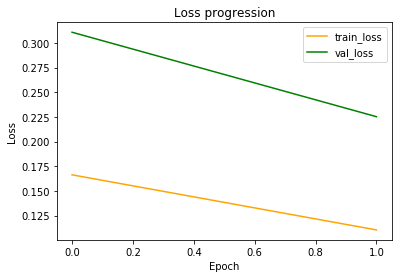

Starting Epoch 2
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.087056	Elapsed time: 0:00:34.449617	FCWeights (Diff, Avg, Total): (2.892944574356079, 0.036760032176971436, 1204.552734375)
Train: [9400/1000 (20%)]	Loss: 0.089480	Elapsed time: 0:01:08.623558	FCWeights (Diff, Avg, Total): (3.4030539989471436, 0.03702550381422043, 1213.251708984375)
Train: [15900/1000 (30%)]	Loss: 0.081577	Elapsed time: 0:01:42.714460	FCWeights (Diff, Avg, Total): (2.6541316509246826, 0.0373864471912384, 1225.0791015625)
Train: [10800/1000 (40%)]	Loss: 0.081584	Elapsed time: 0:02:15.919446	FCWeights (Diff, Avg, Total): (3.072507381439209, 0.03778083622455597, 1238.00244140625)
Train: [20500/1000 (50%)]	Loss: 0.089334	Elapsed time: 0:02:50.385502	FCWeights (Diff, Avg, Total): (2.144472122192383, 0.0381283201277256, 1249.3887939453125)
Train: [26400/1000 (60%)]	Loss: 0.082048	Elapsed time: 0:03:24.623793	FCWeights (Diff, Avg, Total): (3.57726788520813, 0.03842809051275253, 1259.211669921875)


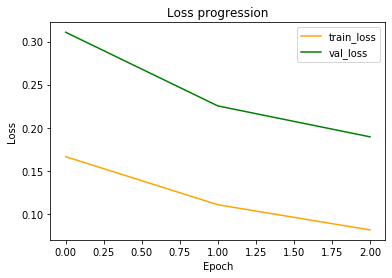

Starting Epoch 3
Will sample from train_loader
Train: [4900/1000 (10%)]	Loss: 0.071682	Elapsed time: 0:00:34.683341	FCWeights (Diff, Avg, Total): (3.2958664894104004, 0.040297478437423706, 1320.4677734375)
Train: [10000/1000 (20%)]	Loss: 0.070687	Elapsed time: 0:01:10.977862	FCWeights (Diff, Avg, Total): (5.631505489349365, 0.04062512144446373, 1331.2039794921875)
Train: [10200/1000 (30%)]	Loss: 0.067438	Elapsed time: 0:01:45.453037	FCWeights (Diff, Avg, Total): (3.4391257762908936, 0.041007671505212784, 1343.7393798828125)
Train: [15200/1000 (40%)]	Loss: 0.073053	Elapsed time: 0:02:20.644380	FCWeights (Diff, Avg, Total): (3.7695183753967285, 0.04140971601009369, 1356.91357421875)
Train: [17500/1000 (50%)]	Loss: 0.065022	Elapsed time: 0:02:55.460153	FCWeights (Diff, Avg, Total): (2.627824306488037, 0.041571859270334244, 1362.2266845703125)
Train: [38400/1000 (60%)]	Loss: 0.061095	Elapsed time: 0:03:30.159942	FCWeights (Diff, Avg, Total): (3.4633326530456543, 0.041980527341365814, 1375.

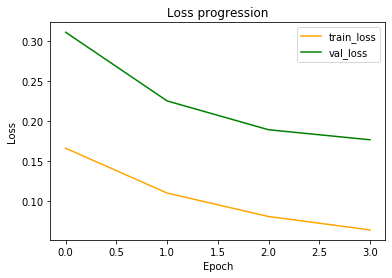

Starting Epoch 4
Will sample from train_loader
Train: [5100/1000 (10%)]	Loss: 0.043695	Elapsed time: 0:00:33.996307	FCWeights (Diff, Avg, Total): (0.5162782073020935, 0.04333154857158661, 1419.88818359375)
Train: [12800/1000 (20%)]	Loss: 0.045283	Elapsed time: 0:01:09.653941	FCWeights (Diff, Avg, Total): (0.46133020520210266, 0.043332554399967194, 1419.921142578125)
Train: [12000/1000 (30%)]	Loss: 0.037310	Elapsed time: 0:01:43.827662	FCWeights (Diff, Avg, Total): (0.5924087166786194, 0.04333331063389778, 1419.9459228515625)
Train: [13600/1000 (40%)]	Loss: 0.034651	Elapsed time: 0:02:19.476470	FCWeights (Diff, Avg, Total): (0.3264421820640564, 0.043331731110811234, 1419.8941650390625)
Train: [32000/1000 (50%)]	Loss: 0.029656	Elapsed time: 0:02:54.133276	FCWeights (Diff, Avg, Total): (0.2483578324317932, 0.04333409294486046, 1419.9715576171875)
Train: [25200/1000 (60%)]	Loss: 0.032307	Elapsed time: 0:03:28.027902	FCWeights (Diff, Avg, Total): (0.5400601029396057, 0.04335019364953041, 14

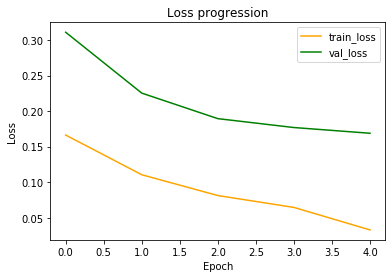

Starting Epoch 5
Will sample from train_loader
Train: [3700/1000 (10%)]	Loss: 0.023784	Elapsed time: 0:00:35.081946	FCWeights (Diff, Avg, Total): (0.5187695026397705, 0.04333595931529999, 1420.03271484375)
Train: [9400/1000 (20%)]	Loss: 0.022605	Elapsed time: 0:01:08.791287	FCWeights (Diff, Avg, Total): (0.29914042353630066, 0.04336749389767647, 1421.0660400390625)
Train: [12000/1000 (30%)]	Loss: 0.021559	Elapsed time: 0:01:43.076327	FCWeights (Diff, Avg, Total): (0.40489983558654785, 0.04335625842213631, 1420.6978759765625)
Train: [20400/1000 (40%)]	Loss: 0.020413	Elapsed time: 0:02:17.299695	FCWeights (Diff, Avg, Total): (0.5867310762405396, 0.043342653661966324, 1420.2520751953125)
Train: [14500/1000 (50%)]	Loss: 0.021639	Elapsed time: 0:02:51.487136	FCWeights (Diff, Avg, Total): (0.4196660816669464, 0.04334490746259689, 1420.325927734375)
Train: [38400/1000 (60%)]	Loss: 0.020926	Elapsed time: 0:03:26.833837	FCWeights (Diff, Avg, Total): (0.4153592884540558, 0.043327536433935165, 14

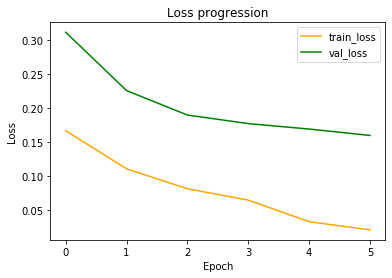

Starting Epoch 6
Will sample from train_loader
Train: [4000/1000 (10%)]	Loss: 0.018423	Elapsed time: 0:00:34.463576	FCWeights (Diff, Avg, Total): (0.7076194286346436, 0.04330188035964966, 1418.916015625)
Train: [9800/1000 (20%)]	Loss: 0.019298	Elapsed time: 0:01:09.326331	FCWeights (Diff, Avg, Total): (0.8108468055725098, 0.04329753667116165, 1418.773681640625)
Train: [12000/1000 (30%)]	Loss: 0.018804	Elapsed time: 0:01:44.277522	FCWeights (Diff, Avg, Total): (0.47358566522598267, 0.043301064521074295, 1418.8892822265625)
Train: [17600/1000 (40%)]	Loss: 0.020338	Elapsed time: 0:02:18.548732	FCWeights (Diff, Avg, Total): (0.3703914284706116, 0.04331682622432709, 1419.40576171875)
Train: [23500/1000 (50%)]	Loss: 0.018734	Elapsed time: 0:02:54.304014	FCWeights (Diff, Avg, Total): (0.5664886236190796, 0.043328769505023956, 1419.797119140625)
Train: [38400/1000 (60%)]	Loss: 0.018652	Elapsed time: 0:03:30.455672	FCWeights (Diff, Avg, Total): (0.7245397567749023, 0.04335024952888489, 1420.500

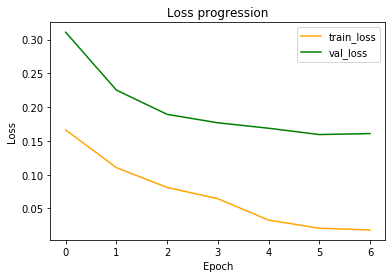

Starting Epoch 7
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.017087	Elapsed time: 0:00:34.290768	FCWeights (Diff, Avg, Total): (0.4173738956451416, 0.043425556272268295, 1422.9686279296875)
Train: [12200/1000 (20%)]	Loss: 0.016834	Elapsed time: 0:01:09.391389	FCWeights (Diff, Avg, Total): (0.40592971444129944, 0.043460048735141754, 1424.098876953125)
Train: [9000/1000 (30%)]	Loss: 0.017057	Elapsed time: 0:01:44.587941	FCWeights (Diff, Avg, Total): (0.46513834595680237, 0.043485499918460846, 1424.932861328125)
Train: [25600/1000 (40%)]	Loss: 0.016982	Elapsed time: 0:02:18.535979	FCWeights (Diff, Avg, Total): (0.6429504156112671, 0.04351362586021423, 1425.8544921875)
Train: [19000/1000 (50%)]	Loss: 0.017106	Elapsed time: 0:02:53.290051	FCWeights (Diff, Avg, Total): (0.34209194779396057, 0.04355541616678238, 1427.223876953125)
Train: [38400/1000 (60%)]	Loss: 0.017575	Elapsed time: 0:03:28.263117	FCWeights (Diff, Avg, Total): (0.6874852180480957, 0.04358542710542679, 142

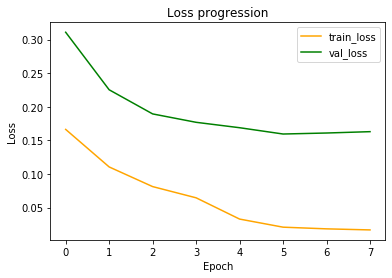

Starting Epoch 8
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.016830	Elapsed time: 0:00:35.716711	FCWeights (Diff, Avg, Total): (0.3951653242111206, 0.04365696385502815, 1430.5513916015625)
Train: [8200/1000 (20%)]	Loss: 0.015883	Elapsed time: 0:01:11.524257	FCWeights (Diff, Avg, Total): (0.3723982274532318, 0.04368279129266739, 1431.397705078125)
Train: [15600/1000 (30%)]	Loss: 0.014677	Elapsed time: 0:01:46.309159	FCWeights (Diff, Avg, Total): (0.34759998321533203, 0.043692994862794876, 1431.7320556640625)
Train: [25600/1000 (40%)]	Loss: 0.016905	Elapsed time: 0:02:22.308617	FCWeights (Diff, Avg, Total): (1.110563039779663, 0.0437043122947216, 1432.1029052734375)
Train: [30000/1000 (50%)]	Loss: 0.016239	Elapsed time: 0:02:56.890868	FCWeights (Diff, Avg, Total): (0.3725346326828003, 0.043721623718738556, 1432.670166015625)
Train: [24600/1000 (60%)]	Loss: 0.014619	Elapsed time: 0:03:30.355742	FCWeights (Diff, Avg, Total): (0.3613971471786499, 0.04373306781053543, 1433

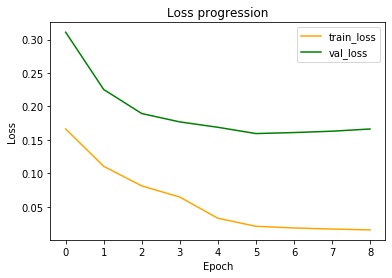

Starting Epoch 9
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.013571	Elapsed time: 0:00:35.062149	FCWeights (Diff, Avg, Total): (0.060332246124744415, 0.04376509040594101, 1434.094482421875)
Train: [8000/1000 (20%)]	Loss: 0.012252	Elapsed time: 0:01:11.283334	FCWeights (Diff, Avg, Total): (0.041352998465299606, 0.04376526176929474, 1434.10009765625)
Train: [8700/1000 (30%)]	Loss: 0.013016	Elapsed time: 0:01:44.594921	FCWeights (Diff, Avg, Total): (0.04872889444231987, 0.04376347362995148, 1434.04150390625)
Train: [16400/1000 (40%)]	Loss: 0.012011	Elapsed time: 0:02:19.689308	FCWeights (Diff, Avg, Total): (0.0493946447968483, 0.04376005008816719, 1433.9293212890625)
Train: [13500/1000 (50%)]	Loss: 0.011125	Elapsed time: 0:02:54.663428	FCWeights (Diff, Avg, Total): (0.07781665772199631, 0.043764032423496246, 1434.059814453125)
Train: [30600/1000 (60%)]	Loss: 0.011119	Elapsed time: 0:03:29.627898	FCWeights (Diff, Avg, Total): (0.05916113778948784, 0.04376327991485596, 14

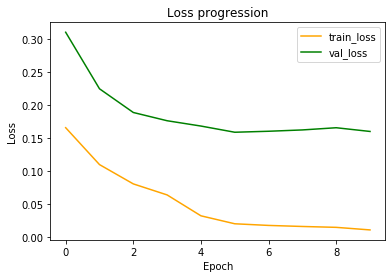

Starting Epoch 10
Will sample from train_loader
Train: [4000/1000 (10%)]	Loss: 0.010257	Elapsed time: 0:00:35.333156	FCWeights (Diff, Avg, Total): (0.061616700142621994, 0.043761346489191055, 1433.9718017578125)
Train: [9400/1000 (20%)]	Loss: 0.009429	Elapsed time: 0:01:09.911119	FCWeights (Diff, Avg, Total): (0.05214904248714447, 0.04376149922609329, 1433.976806640625)
Train: [14700/1000 (30%)]	Loss: 0.010227	Elapsed time: 0:01:43.914654	FCWeights (Diff, Avg, Total): (0.04631274938583374, 0.04376017302274704, 1433.933349609375)
Train: [12800/1000 (40%)]	Loss: 0.009771	Elapsed time: 0:02:18.709937	FCWeights (Diff, Avg, Total): (0.033516570925712585, 0.04376135766506195, 1433.97216796875)
Train: [19500/1000 (50%)]	Loss: 0.011089	Elapsed time: 0:02:53.547555	FCWeights (Diff, Avg, Total): (0.04853455722332001, 0.043760478496551514, 1433.943359375)
Train: [16200/1000 (60%)]	Loss: 0.009747	Elapsed time: 0:03:27.097086	FCWeights (Diff, Avg, Total): (0.032980773597955704, 0.04376246780157089,

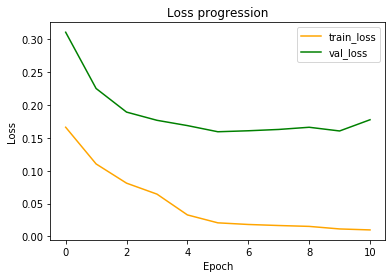

Starting Epoch 11
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.009168	Elapsed time: 0:00:33.887280	FCWeights (Diff, Avg, Total): (0.049472399055957794, 0.043761417269706726, 1433.97412109375)
Train: [10400/1000 (20%)]	Loss: 0.009528	Elapsed time: 0:01:08.699669	FCWeights (Diff, Avg, Total): (0.06750207394361496, 0.04376186057925224, 1433.9886474609375)
Train: [7500/1000 (30%)]	Loss: 0.010078	Elapsed time: 0:01:43.369877	FCWeights (Diff, Avg, Total): (0.08192268013954163, 0.043761737644672394, 1433.984619140625)
Train: [20000/1000 (40%)]	Loss: 0.009700	Elapsed time: 0:02:17.376745	FCWeights (Diff, Avg, Total): (0.07667458802461624, 0.04376230761408806, 1434.0032958984375)
Train: [32000/1000 (50%)]	Loss: 0.009625	Elapsed time: 0:02:51.920613	FCWeights (Diff, Avg, Total): (0.06605881452560425, 0.043763112276792526, 1434.0296630859375)
Train: [30000/1000 (60%)]	Loss: 0.009009	Elapsed time: 0:03:25.584039	FCWeights (Diff, Avg, Total): (0.0428636260330677, 0.043761976063251

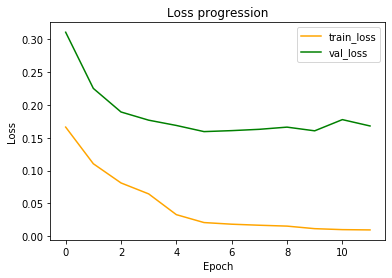

Starting Epoch 12
Will sample from train_loader
Train: [4000/1000 (10%)]	Loss: 0.009029	Elapsed time: 0:00:33.047585	FCWeights (Diff, Avg, Total): (0.043451592326164246, 0.04376232624053955, 1434.00390625)
Train: [12800/1000 (20%)]	Loss: 0.009934	Elapsed time: 0:01:09.131842	FCWeights (Diff, Avg, Total): (0.03873072564601898, 0.0437631756067276, 1434.03173828125)
Train: [15600/1000 (30%)]	Loss: 0.009264	Elapsed time: 0:01:43.093046	FCWeights (Diff, Avg, Total): (0.05370613932609558, 0.04376635700464249, 1434.135986328125)
Train: [20400/1000 (40%)]	Loss: 0.009101	Elapsed time: 0:02:17.005824	FCWeights (Diff, Avg, Total): (0.08881670236587524, 0.04376489669084549, 1434.088134765625)
Train: [25500/1000 (50%)]	Loss: 0.010735	Elapsed time: 0:02:51.463856	FCWeights (Diff, Avg, Total): (0.048695556819438934, 0.043764617294073105, 1434.0789794921875)
Train: [31800/1000 (60%)]	Loss: 0.009546	Elapsed time: 0:03:26.400901	FCWeights (Diff, Avg, Total): (0.07344017922878265, 0.043765224516391754, 1

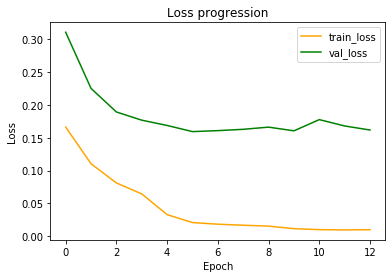

Starting Epoch 13
Will sample from train_loader
Train: [5000/1000 (10%)]	Loss: 0.009434	Elapsed time: 0:00:34.176344	FCWeights (Diff, Avg, Total): (0.04593898728489876, 0.04376403987407684, 1434.06005859375)
Train: [6000/1000 (20%)]	Loss: 0.008991	Elapsed time: 0:01:08.712132	FCWeights (Diff, Avg, Total): (0.048394206911325455, 0.043764449656009674, 1434.073486328125)
Train: [15300/1000 (30%)]	Loss: 0.009727	Elapsed time: 0:01:42.515503	FCWeights (Diff, Avg, Total): (0.0518045499920845, 0.043763935565948486, 1434.056640625)
Train: [14800/1000 (40%)]	Loss: 0.008594	Elapsed time: 0:02:16.471017	FCWeights (Diff, Avg, Total): (0.06998059153556824, 0.04376383498311043, 1434.0533447265625)
Train: [26500/1000 (50%)]	Loss: 0.009072	Elapsed time: 0:02:49.607759	FCWeights (Diff, Avg, Total): (0.04134941101074219, 0.043763838708400726, 1434.053466796875)
Train: [22800/1000 (60%)]	Loss: 0.009243	Elapsed time: 0:03:23.338037	FCWeights (Diff, Avg, Total): (0.06535179913043976, 0.043763794004917145, 

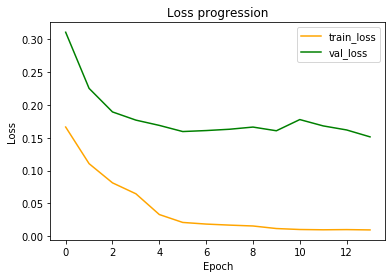

Starting Epoch 14
Will sample from train_loader
Train: [5100/1000 (10%)]	Loss: 0.009744	Elapsed time: 0:00:35.320360	FCWeights (Diff, Avg, Total): (0.006019413936883211, 0.04376562684774399, 1434.112060546875)
Train: [10200/1000 (20%)]	Loss: 0.009038	Elapsed time: 0:01:09.091463	FCWeights (Diff, Avg, Total): (0.0041410354897379875, 0.04376538097858429, 1434.10400390625)
Train: [15600/1000 (30%)]	Loss: 0.009278	Elapsed time: 0:01:43.260369	FCWeights (Diff, Avg, Total): (0.0037433537654578686, 0.04376508295536041, 1434.09423828125)
Train: [19200/1000 (40%)]	Loss: 0.009372	Elapsed time: 0:02:17.458586	FCWeights (Diff, Avg, Total): (0.0052810413762927055, 0.04376537352800369, 1434.103759765625)
Train: [32000/1000 (50%)]	Loss: 0.008387	Elapsed time: 0:02:52.162116	FCWeights (Diff, Avg, Total): (0.0044385287910699844, 0.04376525431871414, 1434.099853515625)
Train: [38400/1000 (60%)]	Loss: 0.009694	Elapsed time: 0:03:26.435041	FCWeights (Diff, Avg, Total): (0.008009083569049835, 0.04376516863

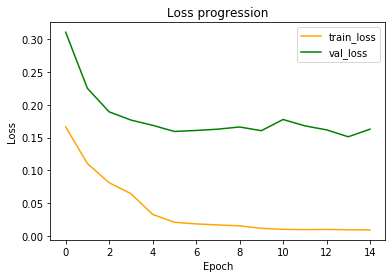

Starting Epoch 15
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.009413	Elapsed time: 0:00:34.459895	FCWeights (Diff, Avg, Total): (0.006722388789057732, 0.0437651202082634, 1434.095458984375)
Train: [10200/1000 (20%)]	Loss: 0.010143	Elapsed time: 0:01:09.195455	FCWeights (Diff, Avg, Total): (0.00606332765892148, 0.04376547783613205, 1434.107177734375)
Train: [9600/1000 (30%)]	Loss: 0.008141	Elapsed time: 0:01:42.337144	FCWeights (Diff, Avg, Total): (0.005391321610659361, 0.04376551881432533, 1434.1085205078125)
Train: [25600/1000 (40%)]	Loss: 0.009160	Elapsed time: 0:02:17.173458	FCWeights (Diff, Avg, Total): (0.005194240249693394, 0.043765392154455185, 1434.1043701171875)
Train: [12500/1000 (50%)]	Loss: 0.010417	Elapsed time: 0:02:52.218541	FCWeights (Diff, Avg, Total): (0.009073946624994278, 0.043765224516391754, 1434.098876953125)
Train: [38400/1000 (60%)]	Loss: 0.008688	Elapsed time: 0:03:26.882384	FCWeights (Diff, Avg, Total): (0.007915324531495571, 0.043765261769

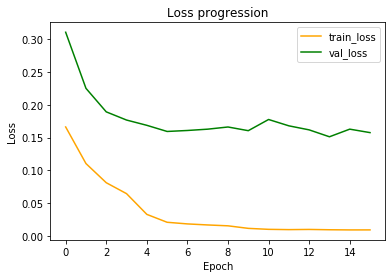

Starting Epoch 16
Will sample from train_loader
Train: [3200/1000 (10%)]	Loss: 0.010235	Elapsed time: 0:00:34.904490	FCWeights (Diff, Avg, Total): (0.004624348133802414, 0.04376543313264847, 1434.105712890625)
Train: [6200/1000 (20%)]	Loss: 0.008690	Elapsed time: 0:01:08.828026	FCWeights (Diff, Avg, Total): (0.004251183941960335, 0.04376509040594101, 1434.094482421875)
Train: [15300/1000 (30%)]	Loss: 0.008634	Elapsed time: 0:01:43.611411	FCWeights (Diff, Avg, Total): (0.007908197119832039, 0.04376540705561638, 1434.1048583984375)
Train: [15200/1000 (40%)]	Loss: 0.008724	Elapsed time: 0:02:18.154311	FCWeights (Diff, Avg, Total): (0.0054425690323114395, 0.043765418231487274, 1434.105224609375)
Train: [23500/1000 (50%)]	Loss: 0.009131	Elapsed time: 0:02:52.786427	FCWeights (Diff, Avg, Total): (0.003570991801097989, 0.04376509413123131, 1434.0946044921875)
Train: [38400/1000 (60%)]	Loss: 0.008400	Elapsed time: 0:03:27.300661	FCWeights (Diff, Avg, Total): (0.006725347600877285, 0.0437655746

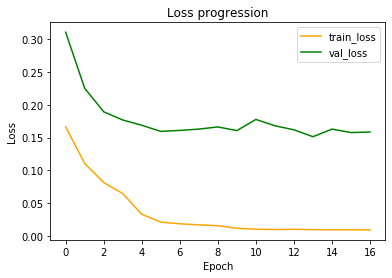

Starting Epoch 17
Will sample from train_loader
Train: [4000/1000 (10%)]	Loss: 0.008614	Elapsed time: 0:00:36.091995	FCWeights (Diff, Avg, Total): (0.006188252009451389, 0.04376550763845444, 1434.108154296875)
Train: [6800/1000 (20%)]	Loss: 0.007963	Elapsed time: 0:01:08.950844	FCWeights (Diff, Avg, Total): (0.004769712686538696, 0.04376530647277832, 1434.1015625)
Train: [13500/1000 (30%)]	Loss: 0.008287	Elapsed time: 0:01:42.895532	FCWeights (Diff, Avg, Total): (0.0049257962964475155, 0.04376576468348503, 1434.1165771484375)
Train: [14800/1000 (40%)]	Loss: 0.009806	Elapsed time: 0:02:16.001824	FCWeights (Diff, Avg, Total): (0.004835527390241623, 0.04376606270670891, 1434.1263427734375)
Train: [23500/1000 (50%)]	Loss: 0.008437	Elapsed time: 0:02:48.615663	FCWeights (Diff, Avg, Total): (0.005164744798094034, 0.043765489012002945, 1434.1075439453125)
Train: [30600/1000 (60%)]	Loss: 0.008685	Elapsed time: 0:03:22.609528	FCWeights (Diff, Avg, Total): (0.0053274380043148994, 0.0437654033303

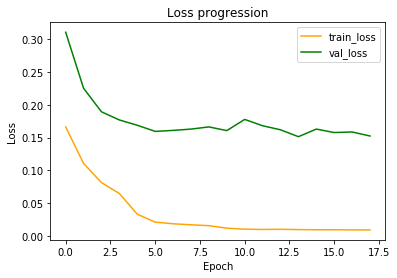

Starting Epoch 18
Will sample from train_loader
Train: [3500/1000 (10%)]	Loss: 0.008485	Elapsed time: 0:00:34.409723	FCWeights (Diff, Avg, Total): (0.0060050711035728455, 0.04376600682735443, 1434.12451171875)
Train: [12800/1000 (20%)]	Loss: 0.009866	Elapsed time: 0:01:08.705911	FCWeights (Diff, Avg, Total): (0.00989055447280407, 0.04376635700464249, 1434.135986328125)
Train: [19200/1000 (30%)]	Loss: 0.009868	Elapsed time: 0:01:43.894890	FCWeights (Diff, Avg, Total): (0.006959826219826937, 0.04376615583896637, 1434.12939453125)
Train: [13600/1000 (40%)]	Loss: 0.009373	Elapsed time: 0:02:19.042089	FCWeights (Diff, Avg, Total): (0.007183822803199291, 0.04376562684774399, 1434.112060546875)
Train: [20500/1000 (50%)]	Loss: 0.008934	Elapsed time: 0:02:52.124477	FCWeights (Diff, Avg, Total): (0.006001254078000784, 0.04376571998000145, 1434.1151123046875)
Train: [38400/1000 (60%)]	Loss: 0.009040	Elapsed time: 0:03:26.311542	FCWeights (Diff, Avg, Total): (0.005413623992353678, 0.04376588761806

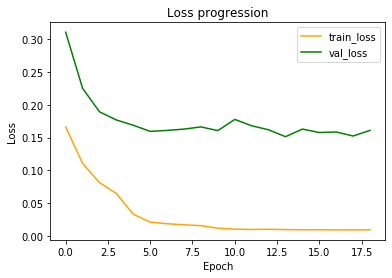

Starting Epoch 19
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.009967	Elapsed time: 0:00:35.930660	FCWeights (Diff, Avg, Total): (0.0006352452328428626, 0.043765269219875336, 1434.100341796875)
Train: [12800/1000 (20%)]	Loss: 0.008944	Elapsed time: 0:01:09.722164	FCWeights (Diff, Avg, Total): (0.0006399755366146564, 0.04376533627510071, 1434.1025390625)
Train: [13200/1000 (30%)]	Loss: 0.008748	Elapsed time: 0:01:44.024138	FCWeights (Diff, Avg, Total): (0.0007622140692546964, 0.04376537352800369, 1434.103759765625)
Train: [16400/1000 (40%)]	Loss: 0.008583	Elapsed time: 0:02:17.847010	FCWeights (Diff, Avg, Total): (0.0004428977845236659, 0.04376539587974548, 1434.1044921875)
Train: [19500/1000 (50%)]	Loss: 0.009159	Elapsed time: 0:02:52.594439	FCWeights (Diff, Avg, Total): (0.0006305078859440982, 0.04376541078090668, 1434.10498046875)
Train: [22800/1000 (60%)]	Loss: 0.008196	Elapsed time: 0:03:25.259835	FCWeights (Diff, Avg, Total): (0.0007511553121730685, 0.04376541078

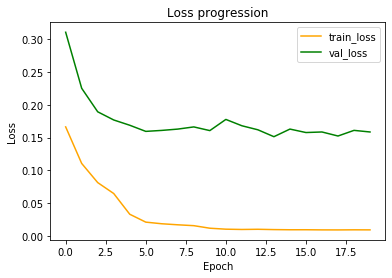

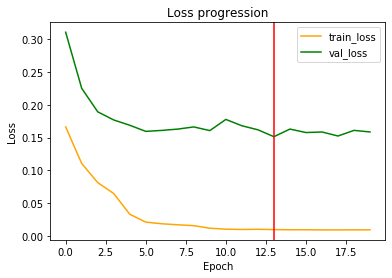

In [3]:
train_loader = DataLoader(training_set, batch_size=1, shuffle=False, num_workers=0)
val_loader = DataLoader(validation_set, batch_size=1, shuffle=False, num_workers=0)
metrics = []  # [EmbeddingCosineSimilarityAndDistanceLossMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics, measure_weights=True)

## Test trained model

### Load model

In [2]:
load_state_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\soft_multisiamese_original_conv_diff_val\training_state_11.pth"
print(load_state_path)
state = torch.load(load_state_path)
model.load_state_dict(state['model'])
model.eval()   

E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\soft_multisiamese_original_conv_diff_val\training_state_11.pth


DataParallel(
  (module): MultiSiameseNet(
    (embedding_net): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): 

### Load test set

In [3]:
test_path = r'C:\Users\root\Data\Angiographie\AA-4'
test_set = get_test_set(test_path)

105 valid frames [32, 136] @21 in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames [50, 159] @22 in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
109 valid frames [44, 152] @22 in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
76 valid frames [56, 131] @20 in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames [53, 131] @21 in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames [35, 155] @21 in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames [35, 147] @20 in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT


### Compute distance and similarity matrices for each video

Batch 1/7 (AA-4 LCA_30LAO25CAU) with 103 sequences


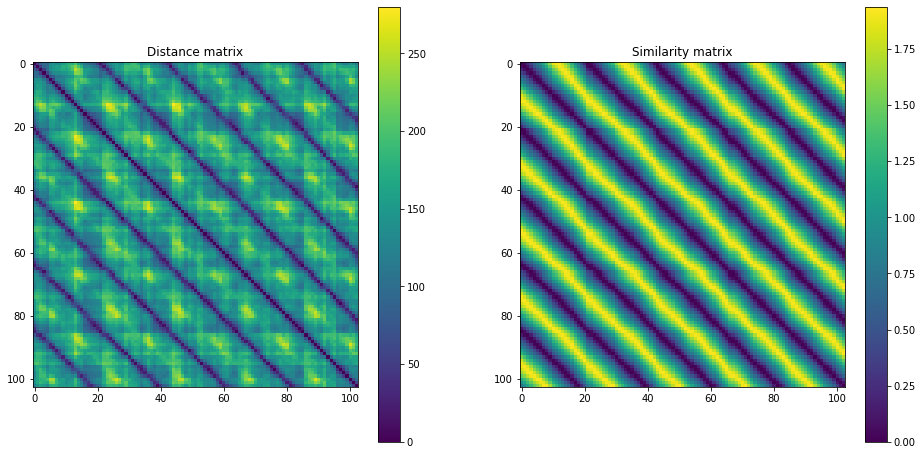

Batch 2/7 (AA-4 LCA_30RAO) with 108 sequences


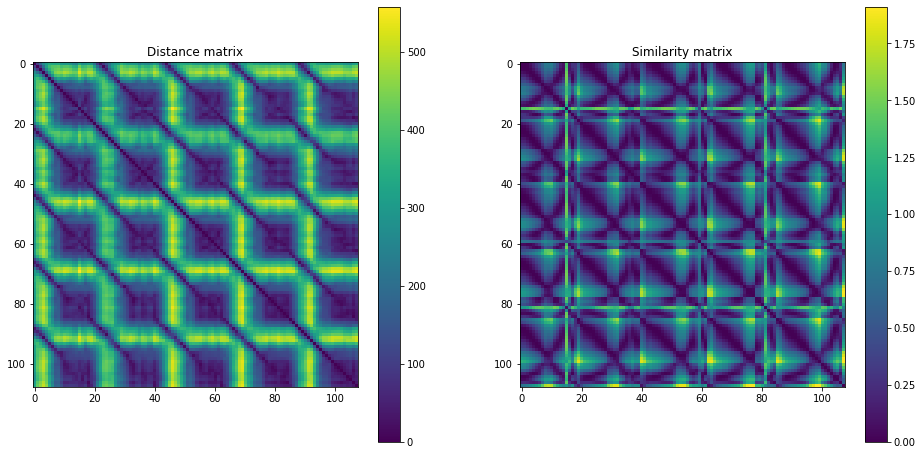

Batch 3/7 (AA-4 LCA_30RAO25CAU) with 107 sequences


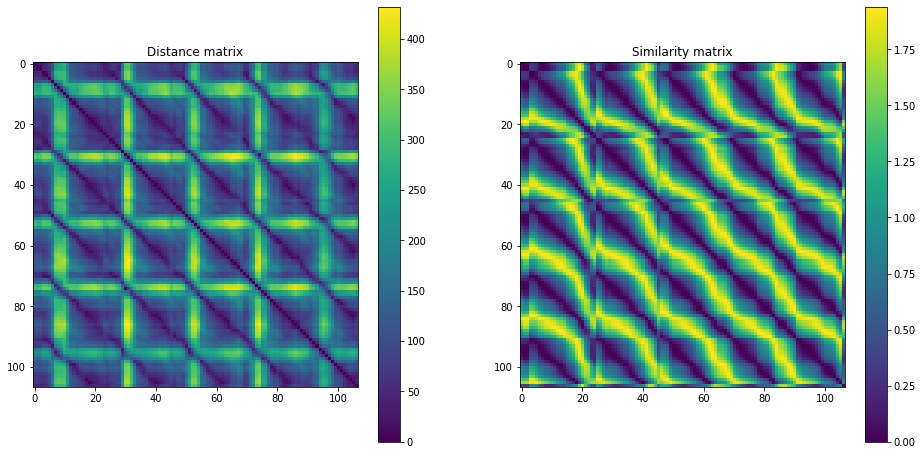

Batch 4/7 (AA-4 LCA_AP) with 74 sequences


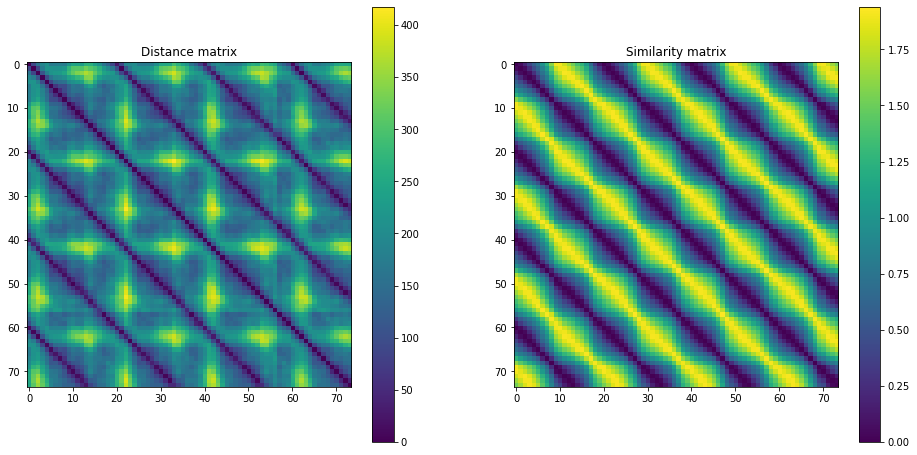

Batch 5/7 (AA-4 LCA_LAT) with 77 sequences


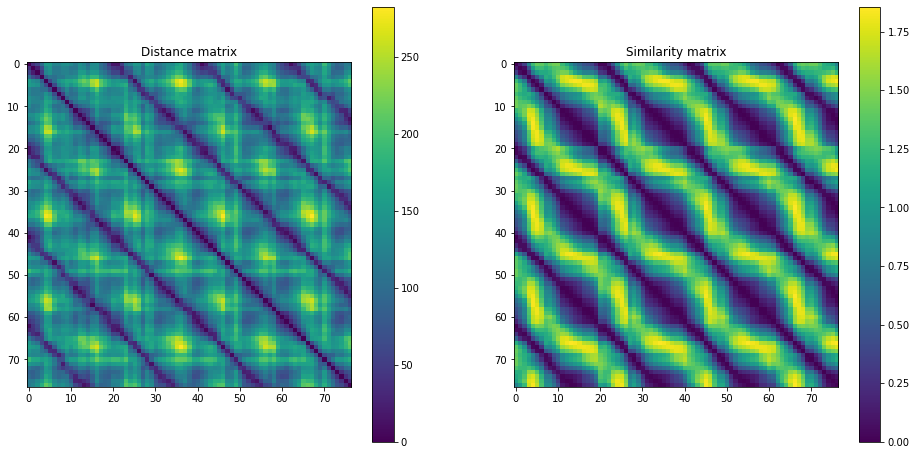

Batch 6/7 (AA-4 RCA_AP) with 119 sequences


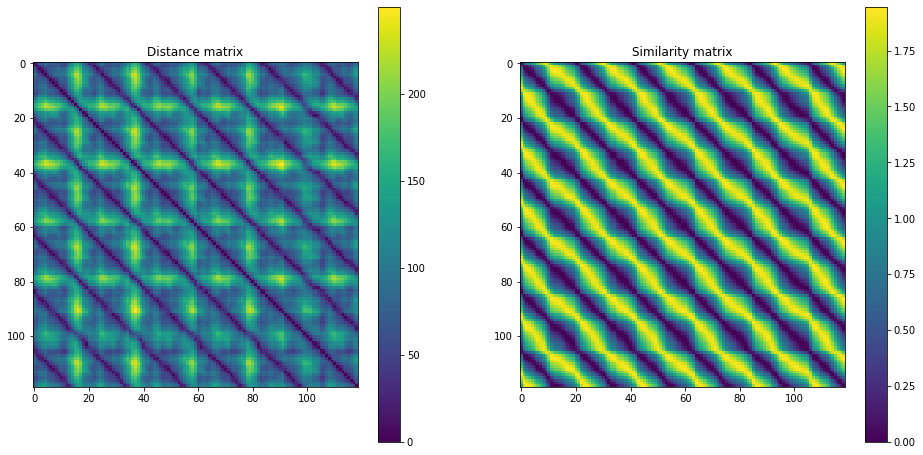

Batch 7/7 (AA-4 RCA_LAT) with 111 sequences


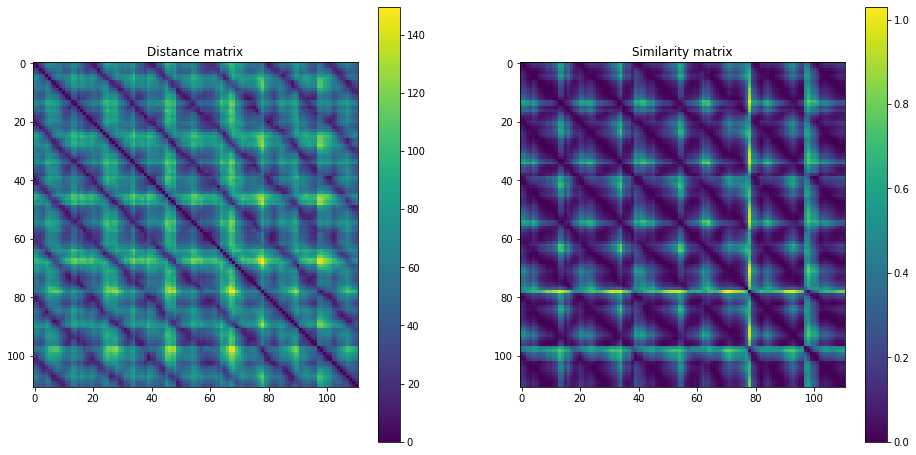

In [4]:
def calc_distance_and_similarity_matrices(embeddings):
    distances = []
    similarities = []
    for i in range(len(embeddings)):
        distances_i = []
        similarities_i = []
        for j in range(len(embeddings)):
            if j < i:
                distances_i.append(distances[j][i])
                similarities_i.append(similarities[j][i])
            elif j == i:
                distances_i.append(0)
                similarities_i.append(0)
            else:
                # Distance
                dist_val = torch.sum(torch.abs(embeddings[i] - embeddings[j]))
                distances_i.append(dist_val.cpu().numpy())
                # Similarity
                normalized_embedding_i = embeddings[i] / torch.norm(embeddings[i])
                normalized_embedding_j = embeddings[j] / torch.norm(embeddings[j])
                sim_val = 1 - normalized_embedding_i.dot(normalized_embedding_j)
                similarities_i.append(sim_val.cpu().numpy())
        distances.append(distances_i)
        similarities.append(similarities_i)
    distances = np.array(distances)
    similarities = np.array(similarities)
    return distances, similarities

with torch.no_grad():
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)
    all_embeddings = []
    names = []
    for batch_index, sequences in enumerate(test_loader):
        name = sequences[1][0]
        sequences = sequences[0]
        
        # sequences: (batch, video_frame, channel, width, height)
        embeddings = []
        print (f"Batch {batch_index + 1}/{len(test_loader)} ({name}) with {len(sequences[0])} sequences")
        embeddings = model(sequences[0])
        all_embeddings.append(embeddings)
        names.append(name)
        
        distance_matrix, similarity_matrix = calc_distance_and_similarity_matrices(embeddings)
        
        figure(figsize=(16,8))
        
        plt.subplot(1, 2, 1)
        plt.imshow(distance_matrix)
        plt.colorbar()
        plt.title(f"Distance matrix")
        
        plt.subplot(1, 2, 2)
        plt.imshow(similarity_matrix)
        plt.colorbar()
        plt.title(f"Similarity matrix")
        
        plt.show()

### Compute distance and similarity matrices for video comparison

Combinations of AA-4
Comparison of AA-4 LCA_30LAO25CAU and AA-4 LCA_30RAO


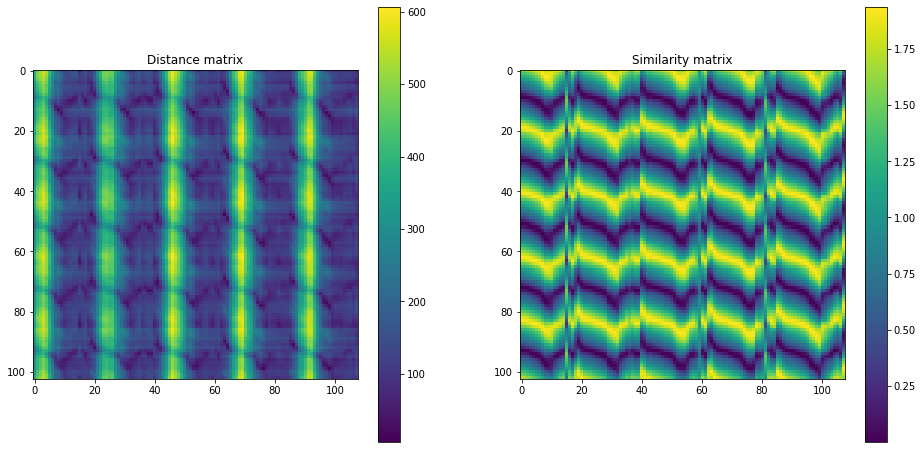

Comparison of AA-4 LCA_30LAO25CAU and AA-4 LCA_30RAO25CAU


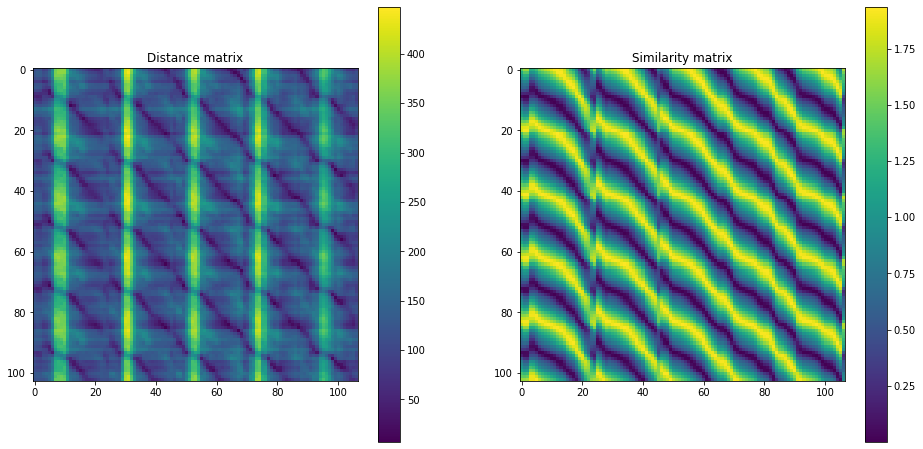

Comparison of AA-4 LCA_30LAO25CAU and AA-4 LCA_AP


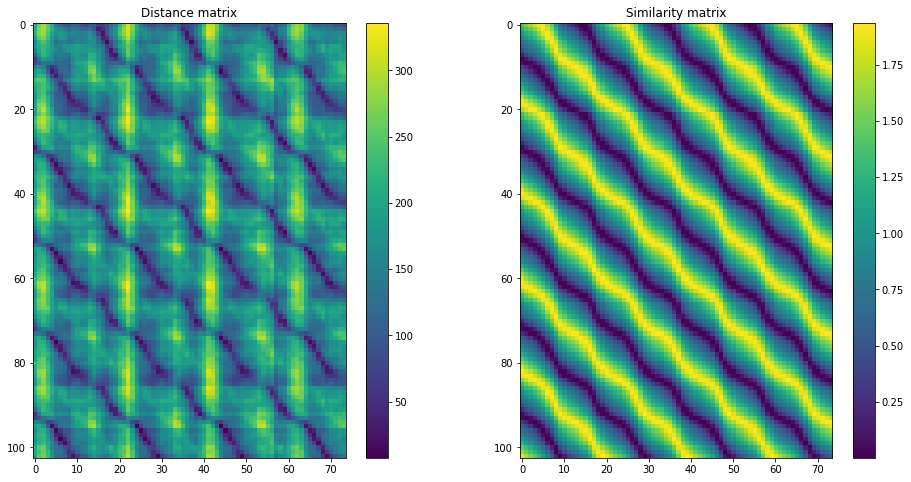

Comparison of AA-4 LCA_30LAO25CAU and AA-4 LCA_LAT


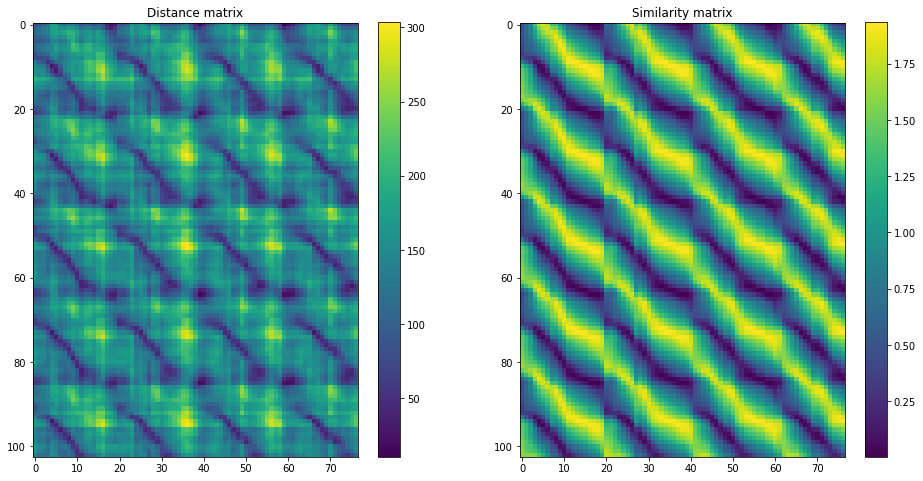

Comparison of AA-4 LCA_30LAO25CAU and AA-4 RCA_AP


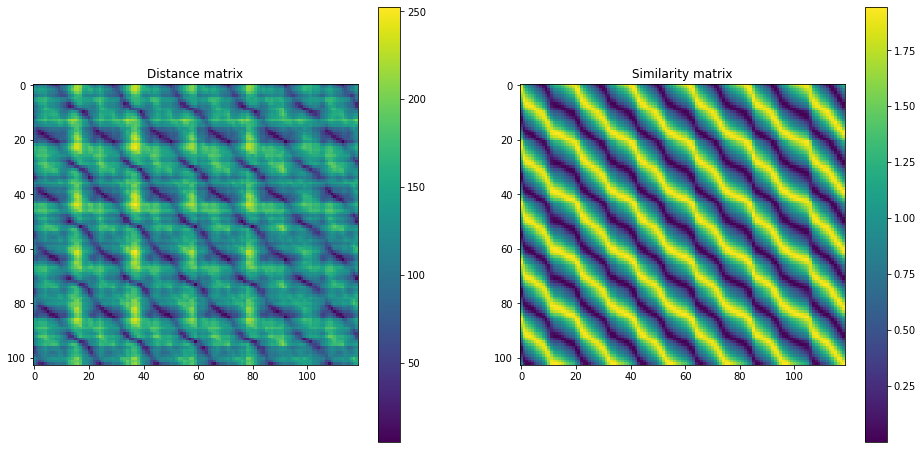

Comparison of AA-4 LCA_30LAO25CAU and AA-4 RCA_LAT


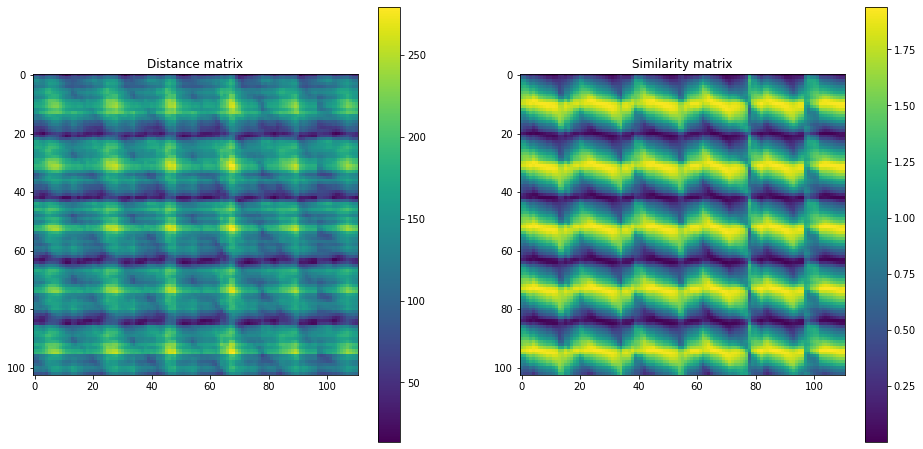

Comparison of AA-4 LCA_30RAO and AA-4 LCA_30RAO25CAU


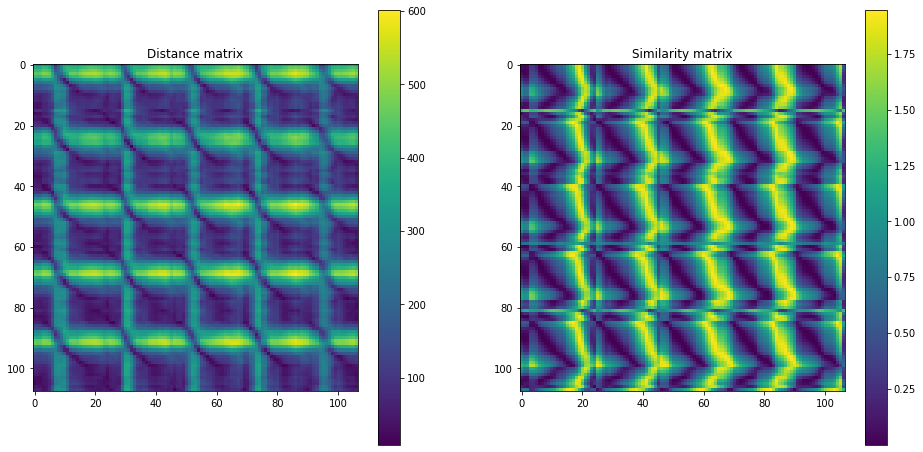

Comparison of AA-4 LCA_30RAO and AA-4 LCA_AP


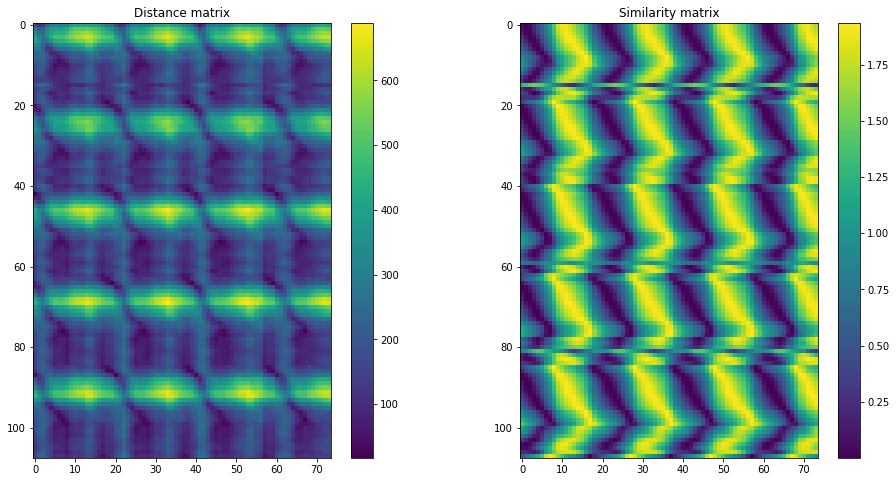

Comparison of AA-4 LCA_30RAO and AA-4 LCA_LAT


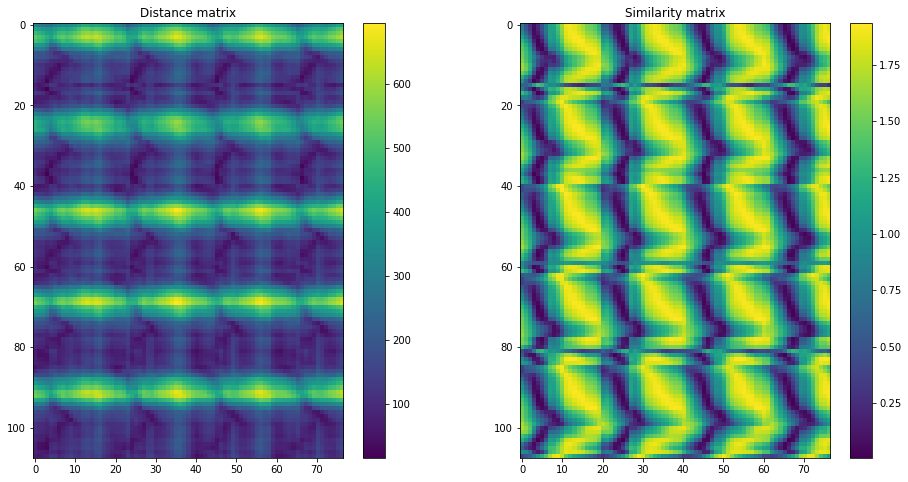

Comparison of AA-4 LCA_30RAO and AA-4 RCA_AP


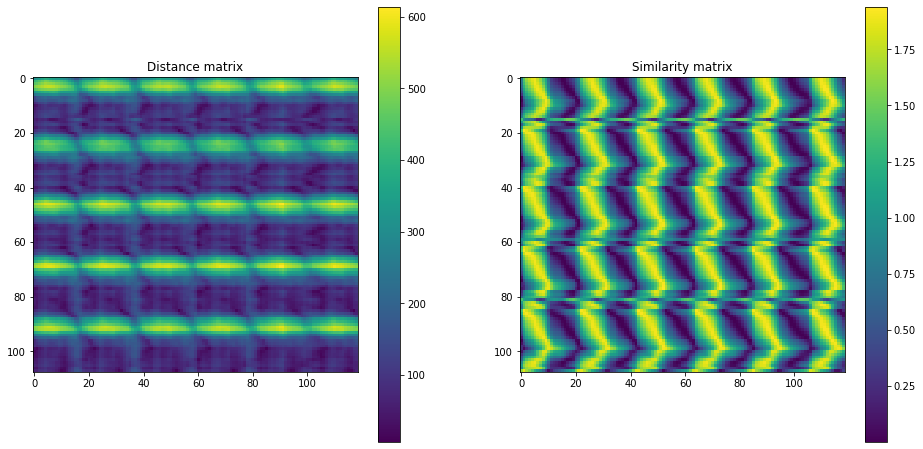

Comparison of AA-4 LCA_30RAO and AA-4 RCA_LAT


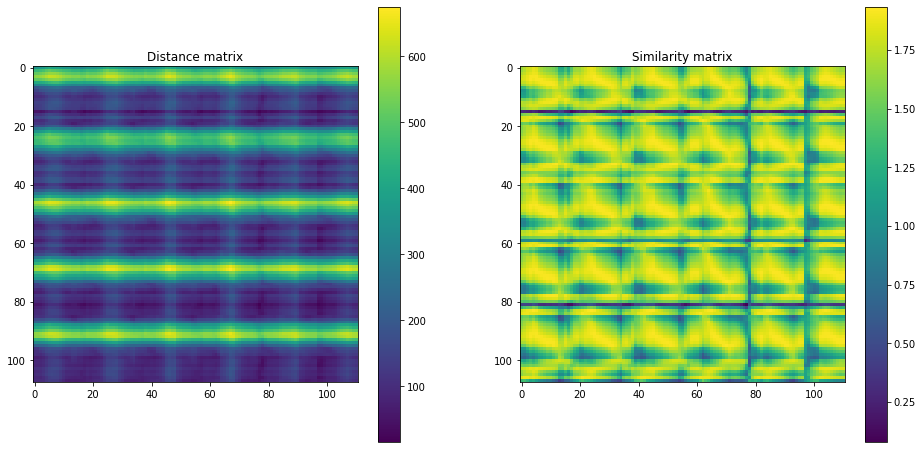

Comparison of AA-4 LCA_30RAO25CAU and AA-4 LCA_AP


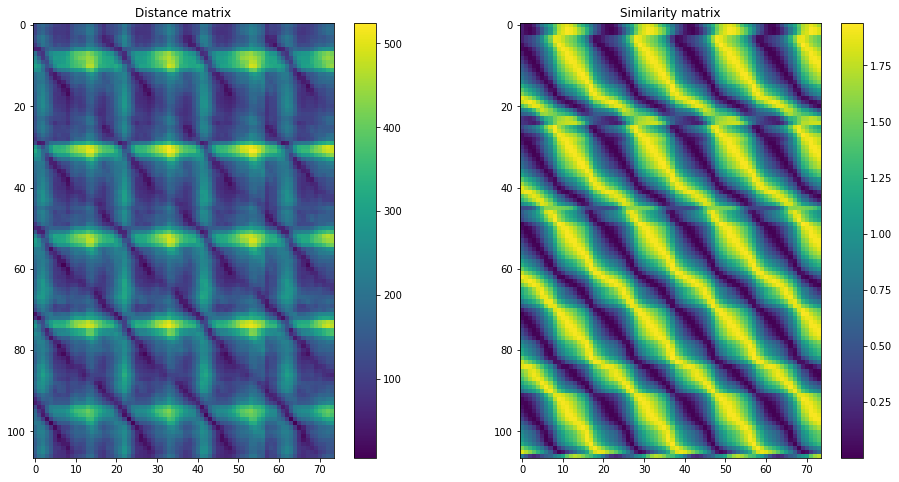

Comparison of AA-4 LCA_30RAO25CAU and AA-4 LCA_LAT


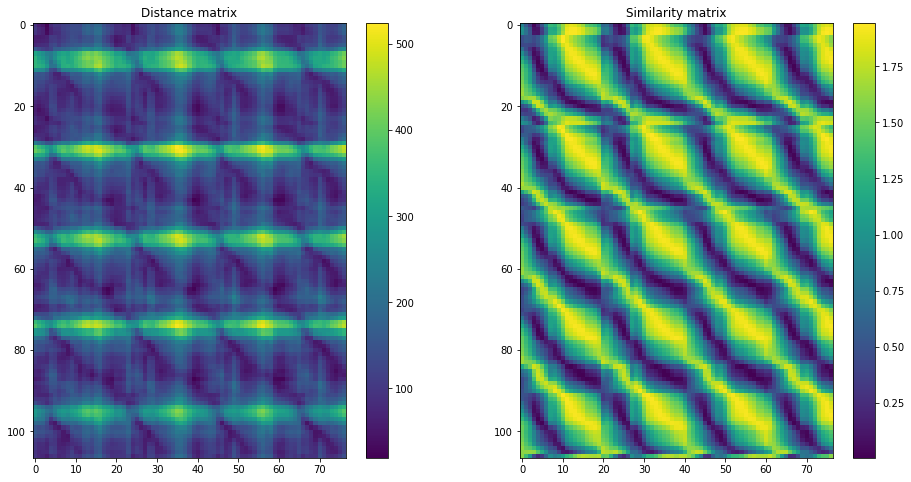

Comparison of AA-4 LCA_30RAO25CAU and AA-4 RCA_AP


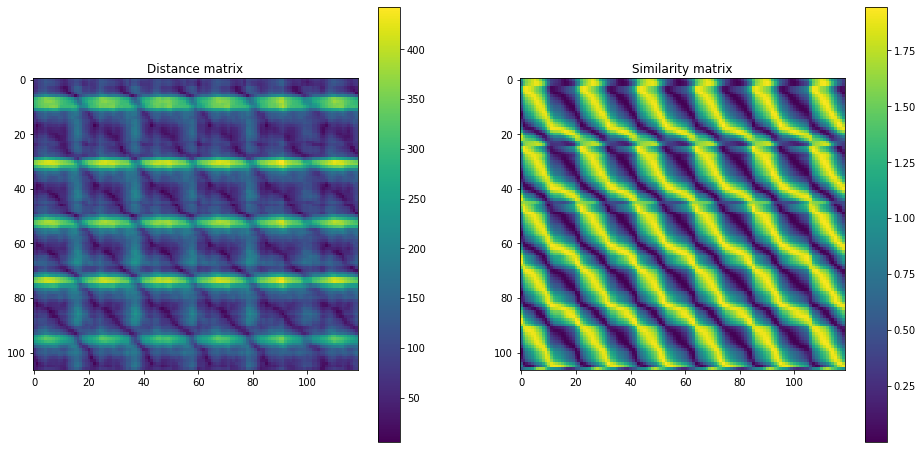

Comparison of AA-4 LCA_30RAO25CAU and AA-4 RCA_LAT


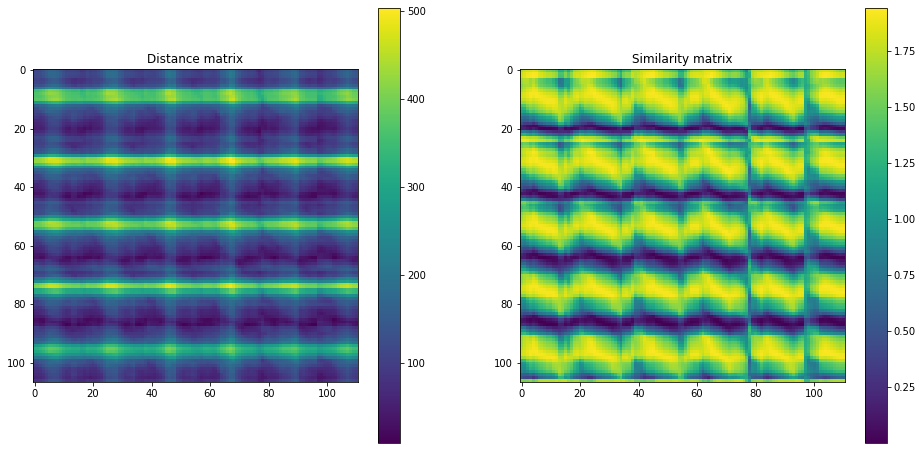

Comparison of AA-4 LCA_AP and AA-4 LCA_LAT


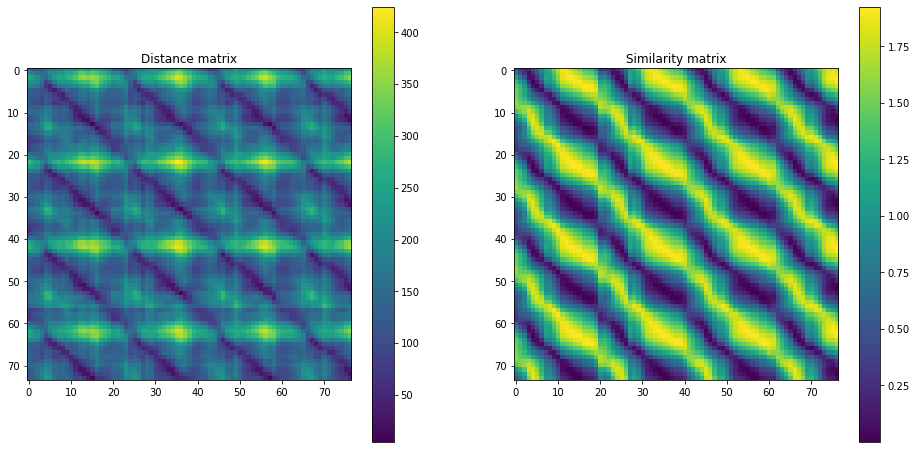

Comparison of AA-4 LCA_AP and AA-4 RCA_AP


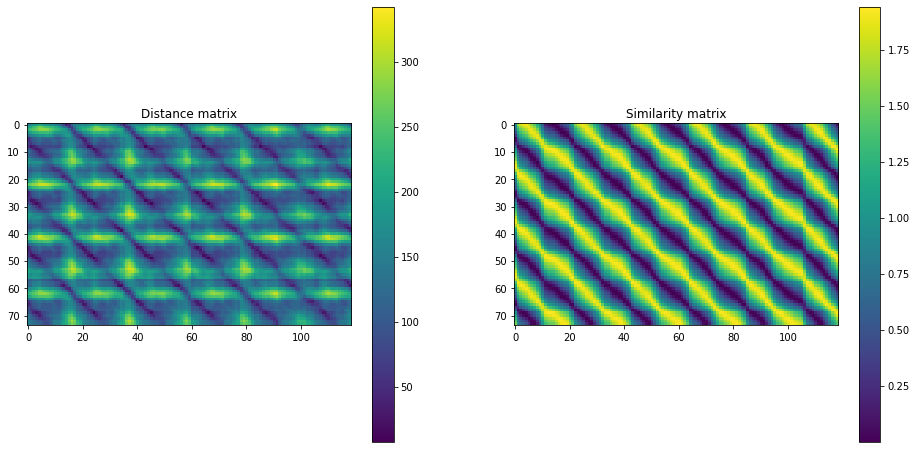

Comparison of AA-4 LCA_AP and AA-4 RCA_LAT


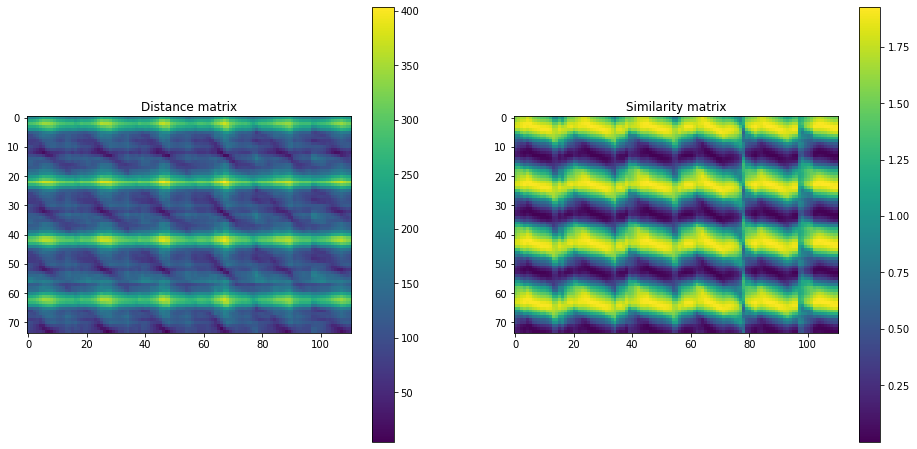

Comparison of AA-4 LCA_LAT and AA-4 RCA_AP


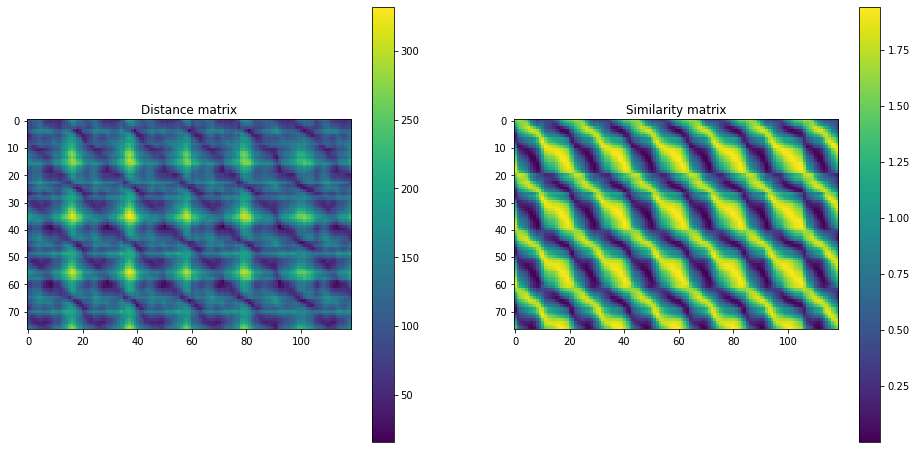

Comparison of AA-4 LCA_LAT and AA-4 RCA_LAT


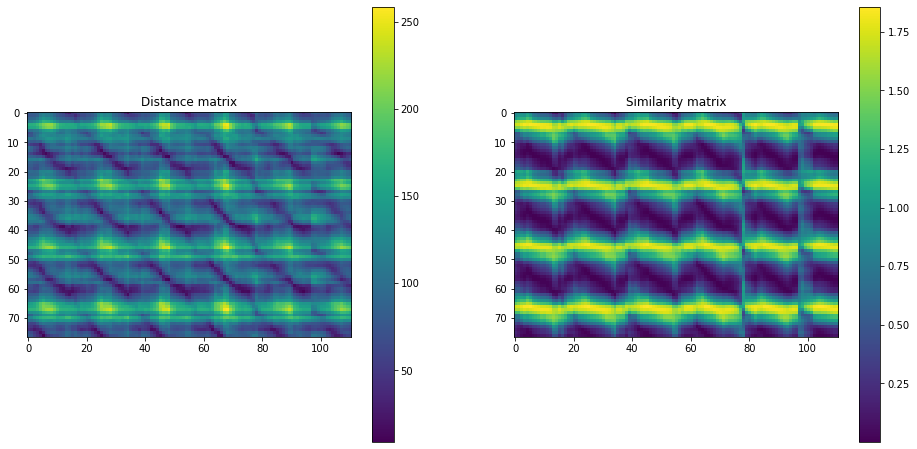

Comparison of AA-4 RCA_AP and AA-4 RCA_LAT


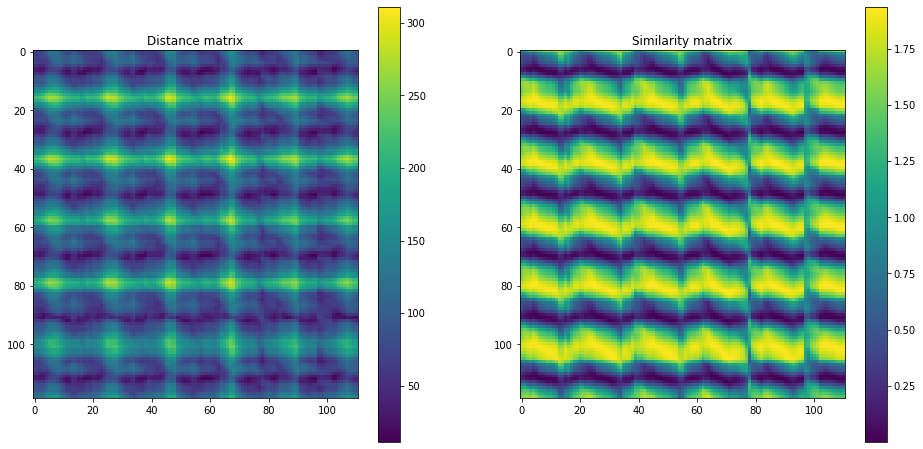

In [5]:
def calc_distance_and_similarity_matrices2(embeddings1, embeddings2):
    distances = []
    similarities = []
    for i in range(len(embeddings1)):
        distances_i = []
        similarities_i = []
        for j in range(len(embeddings2)):
            # Distance
            dist_val = torch.sum(torch.abs(embeddings1[i] - embeddings2[j]))
            distances_i.append(dist_val.cpu().numpy())
            # Similarity
            normalized_embedding_i = embeddings1[i] / torch.norm(embeddings1[i])
            normalized_embedding_j = embeddings2[j] / torch.norm(embeddings2[j])
            sim_val = 1 - normalized_embedding_i.dot(normalized_embedding_j)
            similarities_i.append(sim_val.cpu().numpy())
        distances.append(distances_i)
        similarities.append(similarities_i)
    distances = np.array(distances)
    similarities = np.array(similarities)
    return distances, similarities

with torch.no_grad():
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)
    try:
        all_embeddings
    except NameError:
        all_embeddings = []
        compute_embeddings = True
    else:
        compute_embeddings = False
    if compute_embeddings:
        print (f"Computing embeddings")
        names = []
        for batch_index, sequences in enumerate(test_loader):
            name = sequences[1][0]
            sequences = sequences[0]

            # sequences: (batch, video_frame, channel, width, height)
            embeddings = []
            print (f"Batch {batch_index + 1}/{len(test_loader)} ({name}) with {len(sequences[0])} sequences")
            embeddings = model(sequences[0])
            all_embeddings.append(embeddings)
            names.append(name)
    
    distance_matrices = {}
    similarity_matrices = {}
    current_name = None
    for i in range(len(all_embeddings)):
        name_i = names[i].split(' ')[0]
        if not name_i == current_name:
            print(f"Combinations of {name_i}")
        distance_matrices[names[i]] = {}
        similarity_matrices[names[i]] = {}
        current_name = name_i
        for j in range(i+1, len(all_embeddings)):
            if name_i == names[j].split(' ')[0]:
                print(f"Comparison of {names[i]} and {names[j]}")
                distance_matrix, similarity_matrix = calc_distance_and_similarity_matrices2(all_embeddings[i], all_embeddings[j])
                distance_matrices[names[i]][names[j]] = distance_matrix
                similarity_matrices[names[i]][names[j]] = similarity_matrix
                
                figure(figsize=(16,8))

                plt.subplot(1, 2, 1)
                plt.imshow(distance_matrix)
                plt.colorbar()
                plt.title(f"Distance matrix")

                plt.subplot(1, 2, 2)
                plt.imshow(similarity_matrix)
                plt.colorbar()
                plt.title(f"Similarity matrix")

                plt.show()

### Compare similar frames

AA-4 LCA_30LAO25CAU torch.Size([103, 3, 224, 224])
AA-4 LCA_30LAO25CAU torch.Size([103, 3, 224, 224])
AA-4 LCA_30RAO torch.Size([108, 3, 224, 224])


c:\logiciels\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


AA-4 LCA_30RAO25CAU torch.Size([107, 3, 224, 224])
AA-4 LCA_AP torch.Size([74, 3, 224, 224])
AA-4 LCA_LAT torch.Size([77, 3, 224, 224])
AA-4 RCA_AP torch.Size([119, 3, 224, 224])
AA-4 RCA_LAT torch.Size([111, 3, 224, 224])
AA-4 LCA_30RAO torch.Size([108, 3, 224, 224])
AA-4 LCA_30LAO25CAU torch.Size([103, 3, 224, 224])
AA-4 LCA_30RAO torch.Size([108, 3, 224, 224])
AA-4 LCA_30RAO25CAU torch.Size([107, 3, 224, 224])
AA-4 LCA_AP torch.Size([74, 3, 224, 224])
AA-4 LCA_LAT torch.Size([77, 3, 224, 224])
AA-4 RCA_AP torch.Size([119, 3, 224, 224])
AA-4 RCA_LAT torch.Size([111, 3, 224, 224])
AA-4 LCA_30RAO25CAU torch.Size([107, 3, 224, 224])
AA-4 LCA_30LAO25CAU torch.Size([103, 3, 224, 224])
AA-4 LCA_30RAO torch.Size([108, 3, 224, 224])
AA-4 LCA_30RAO25CAU torch.Size([107, 3, 224, 224])
AA-4 LCA_AP torch.Size([74, 3, 224, 224])
AA-4 LCA_LAT torch.Size([77, 3, 224, 224])
AA-4 RCA_AP torch.Size([119, 3, 224, 224])
AA-4 RCA_LAT torch.Size([111, 3, 224, 224])
AA-4 LCA_AP torch.Size([74, 3, 224, 224]

<Figure size 432x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

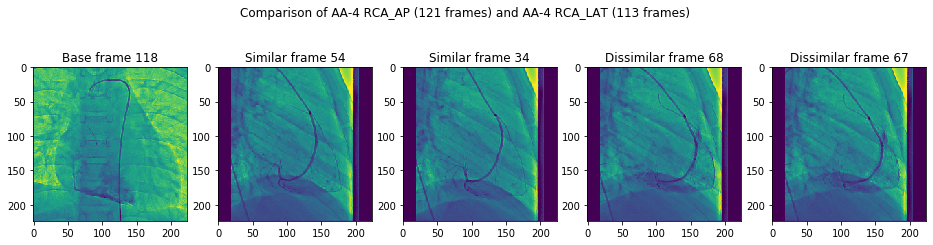

In [9]:
import cv2
nb_max_frames = 2
nb_min_frames = 2
total_frames = nb_max_frames + nb_min_frames + 1
for batch_index_a, sequences_a in enumerate(test_loader):
    name_a = sequences_a[1][0]
    sequences_a = sequences_a[0][0]
    print(name_a, sequences_a.shape)
    for batch_index_b, sequences_b in enumerate(test_loader):
        name_b = sequences_b[1][0]
        sequences_b = sequences_b[0][0]
        print(name_b, sequences_b.shape)
        if name_b in distance_matrices[name_a]:
            distance_matrix = distance_matrices[name_a][name_b]
            video_frames = []
            for frame_a in range(len(distance_matrix)):
                max_frame_indices = distance_matrix[frame_a].argsort()[:nb_max_frames]
                min_frame_indices = distance_matrix[frame_a].argsort()[-nb_max_frames:]
                img_frame_a = sequences_a[frame_a][-1]
        
                plt.clf()
                figure(figsize=(16,4))
                plt.subplot(1, total_frames, 1)
                plt.imshow(img_frame_a)
                plt.title(f"Base frame {frame_a}")
                for i, frame_b in enumerate(max_frame_indices):
                    img_frame_b = sequences_b[frame_b][-1]
                    plt.subplot(1, total_frames, i+2)
                    plt.imshow(img_frame_b)
                    plt.title(f"Similar frame {frame_b}")
                for i, frame_b in enumerate(min_frame_indices):
                    img_frame_b = sequences_b[frame_b][-1]
                    plt.subplot(1, total_frames, i+len(max_frame_indices)+2)
                    plt.imshow(img_frame_b)
                    plt.title(f"Dissimilar frame {frame_b}")
                plt.suptitle(f"Comparison of {name_a} ({sequences_a.shape[0]+2} frames) and {name_b} ({sequences_b.shape[0]+2} frames)")
                # plt.show()
                comparison_save_path = save_path + f"\\comparisons\\{name_a}\\{name_b}"
                if not os.path.isdir(comparison_save_path):
                    os.makedirs(comparison_save_path)
                plt.savefig(comparison_save_path + f"\\frame_{frame_a}.png")
                
#                 frame_b = np.argmax(distance_matrix[frame_a])
#                 img_frame_a = sequences_a[frame_a][-1]
#                 img_frame_b = sequences_b[frame_b][-1]
#                 video_frame = np.concatenate((img_frame_a, img_frame_b), axis=-1)
#                 video_frame = np.uint8(video_frame * 255)
# #                 video_frame = video_frame[np.newaxis, :, :]
# #                 video_frame = np.repeat(video_frame, 3, axis=0)
#                 video_frames.append(video_frame)
                
#                 figure(figsize=(16,8))
#                 plt.subplot(1, 2, 1)
#                 plt.imshow(img_frame_a)
#                 plt.title(f"Frame {frame_a}")
#                 plt.subplot(1, 2, 2)
#                 plt.imshow(img_frame_b)
#                 plt.title(f"Frame {frame_b}")
#                 plt.show()
                
#             vid = cv2.VideoWriter(save_path + f'/{name_a} with {name_b}.avi', cv2.VideoWriter_fourcc(*'XVID'), 15, video_frame.shape)
#             for i in range(len(video_frames)):
#                 vid.write(video_frames[i])
#             vid.release()
                
                
# for video_a in distance_matrices:
#     video_pairs = distance_matrices[video_a]
#     print(video_a, len(video_pairs))
#     for video_b in video_pairs:
#         distance_matrix = video_pairs[video_b]
#         print("-", video_b, distance_matrix.shape)
#         for frame_a in distance_matrix:
#             plt.plot(frame_a)
#             plt.show()

Matrix shape (108, 107)
Starting point (0, 7)
(101, 106) 8969.407698631287


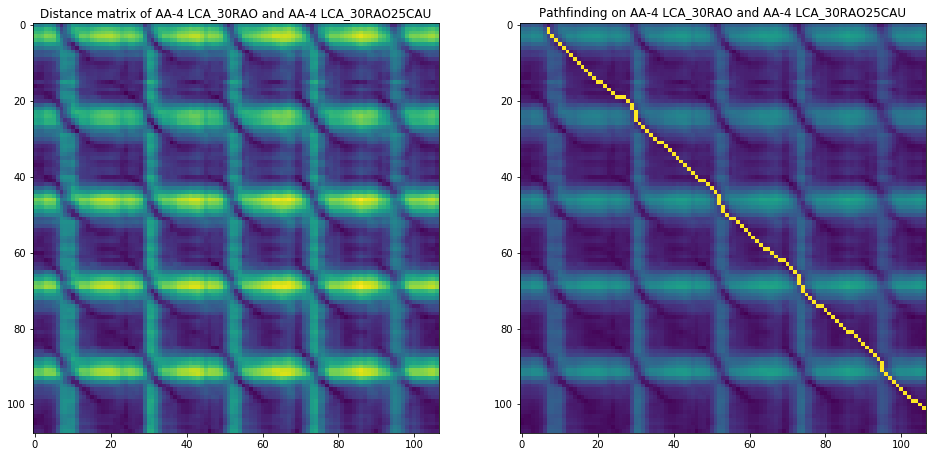

Matrix shape (107, 74)
Starting point (0, 17)
(65, 73) 5073.853615760803


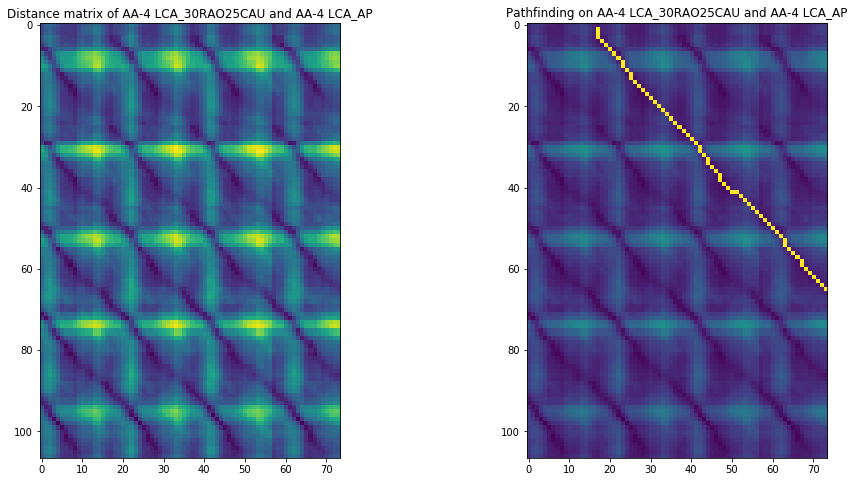

In [15]:
import utils
reload(utils)
from utils import pathfinding

save_pairs = False
good_angle_pairs = [
    ("AA-4 LCA_30RAO", "AA-4 LCA_30RAO25CAU"),
    ("AA-4 LCA_30RAO25CAU", "AA-4 LCA_AP")
]

for batch_index_a, sequences_a in enumerate(test_loader):
    name_a = sequences_a[1][0]
    sequences_a = sequences_a[0][0]
    for batch_index_b, sequences_b in enumerate(test_loader):
        name_b = sequences_b[1][0]
        sequences_b = sequences_b[0][0]
        if (name_a, name_b) not in good_angle_pairs:
            continue
        if name_b in distance_matrices[name_a]:
            distance_matrix = np.copy(distance_matrices[name_a][name_b])
            hb_freq = 22
            node = pathfinding(distance_matrix, hb_freq)
            print(node.point, node.cost)
            comparison_save_path = save_path + f"\\comparisons\\{name_a}\\{name_b}\\pathfinding"
            if not os.path.isdir(comparison_save_path):
                os.makedirs(comparison_save_path)
            pairs = []
            figure(figsize=(16,8))
            plt.subplot(1, 2, 1)
            plt.imshow(distance_matrix)
            plt.title(f"Distance matrix of {name_a} and {name_b}")
            while node.parent is not None:
                pairs.append(node.point)
                distance_matrix[node.point] = 1000
                node = node.parent
            plt.subplot(1, 2, 2)
            plt.imshow(distance_matrix)
            plt.title(f"Pathfinding on {name_a} and {name_b}")
            plt.show()
            if save_pairs:
                for i, pair in enumerate(reversed(pairs)):
                    plt.subplot(1, 2, 1)
                    plt.imshow(sequences_a[pair[0], -1])
                    plt.title(f"Frame {pair[0]}")
                    plt.subplot(1, 2, 2)
                    plt.imshow(sequences_b[pair[1], -1])
                    plt.title(f"Frame {pair[1]}")
                    plt.suptitle(f"{name_a} vs {name_b}")
                    plt.savefig(comparison_save_path + f"\\{i}.png")